In [4]:
import sys
import matplotlib, sklearn, xgboost, pandas

print("✅ Python path:", sys.executable)
print("📦 matplotlib:", matplotlib.__version__)
print("📦 sklearn:", sklearn.__version__)
print("📦 xgboost:", xgboost.__version__)


ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# ================================================
# STEP 1: Load combined dataset
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import os
import re

# Load data
data_path = "../data/combined_data.csv"
df = pd.read_csv(data_path)

print("✅ Data loaded successfully!")
print("Shape:", df.shape)
df.head()


C:\Users\akkap\AppData\Local\Temp\ipykernel_15284\991533162.py:20: DtypeWarning: Columns (0,1,2,4,7,8,9,10,15,16,17,18,19,21,28,29,30,31,32,33,34,35,38,39,41,43,46,48,49,51,53,54,56,57,65,67,68,70,72,77,82,83,84,85,86,88,90,93,94,96,97,98,99,102,103,104,105,106,107,108,111,114,115,116,117,118,120,121,122,123,124,125,126,128,129,132,133,135,136,137,138,139,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


✅ Data loaded successfully!
Shape: (46686, 143)


,feature_9,feature_78,feature_61,number_of_views,feature_20,clubhouse,indoorgames,feature_28,feature_29,feature_36,...,feature_54,distance_from_the_airport,feature_33,feature_58,feature_10,feature_72,feature_32,landscapedgardens,feature_41,resale
0,Land Contour,Yr Sold,Garage Finish,NaN,Year Built,NaN,NaN,Exter Qual,Exter Cond,BsmtFin Type 2,...,Kitchen Qual,NaN,Bsmt Exposure,Fireplace Qu,Utilities,Pool Area,Bsmt Cond,NaN,Heating QC,NaN
1,Lvl,2010,Fin,NaN,1960,NaN,NaN,TA,TA,Unf,...,TA,NaN,Gd,Gd,AllPub,0,Gd,NaN,Fa,NaN
2,Lvl,2010,Unf,NaN,1961,NaN,NaN,TA,TA,LwQ,...,TA,NaN,No,NaN,AllPub,0,TA,NaN,TA,NaN
3,Lvl,2010,Unf,NaN,1958,NaN,NaN,TA,TA,Unf,...,Gd,NaN,No,NaN,AllPub,0,TA,NaN,TA,NaN
4,Lvl,2010,Fin,NaN,1968,NaN,NaN,Gd,TA,Unf,...,Ex,NaN,No,TA,AllPub,0,TA,NaN,Ex,NaN


In [ ]:
# ================================================
# STEP 2: Inspect and clean data
# ================================================

print(f"Original shape: {df.shape}")

# Drop columns with too many missing values (>40%)
threshold = 0.4 * len(df)
df = df.dropna(axis=1, thresh=threshold)
print(f"After dropping high-missing columns: {df.shape}")

# Drop duplicates
df = df.drop_duplicates()

# Confirm target column exists
if 'sale_price' not in df.columns:
    raise ValueError("❌ Target column 'sale_price' not found!")

# 🧹 Clean and convert sale_price
def clean_price(value):
    if pd.isna(value):
        return np.nan
    s = str(value).lower().strip()
    s = re.sub(r"[₹$,]", "", s)
    s = s.replace("rs", "").replace("inr", "").replace("usd", "")
    s = s.replace("price", "").replace(" ", "")
    if "lac" in s or "l" in s:
        num = re.findall(r"\d+\.?\d*", s)
        return float(num[0]) * 1e5 if num else np.nan
    if "cr" in s or "crore" in s:
        num = re.findall(r"\d+\.?\d*", s)
        return float(num[0]) * 1e7 if num else np.nan
    try:
        return float(s)
    except:
        return np.nan

# Remove header-like text rows (e.g. "SalePrice")
df = df[~df['sale_price'].astype(str).str.contains("saleprice", case=False, na=False)]

df["sale_price"] = df["sale_price"].apply(clean_price)

# Filter valid numeric prices
df = df.dropna(subset=["sale_price"])
df = df[df["sale_price"] > 1000]

print("✅ Cleaned sale_price successfully.")
print(df["sale_price"].describe())


Original shape: (46686, 143)
After dropping high-missing columns: (46686, 40)
✅ Cleaned sale_price successfully.
count    3.306800e+04
mean     1.058902e+07
std      2.271744e+07
min      1.278900e+04
25%      3.300000e+06
50%      6.000000e+06
75%      1.100000e+07
max      8.546000e+08
Name: sale_price, dtype: float64


In [ ]:
# ================================================
# STEP 3: Split features (X) and target (y)
# ================================================
if 'sale_price' not in df.columns:
    raise ValueError("❌ 'sale_price' column missing!")

X = df.drop(columns=['sale_price'], errors='ignore')
y = df['sale_price'].astype(float)

print("✅ Feature matrix shape:", X.shape)
print("✅ Target vector shape:", y.shape)


✅ Feature matrix shape: (33068, 39)
✅ Target vector shape: (33068,)


In [ ]:
# ================================================
# STEP 4: Train/Test Split
# ================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Train:", X_train.shape, "Test:", X_test.shape)
print("✅ y_train dtype:", y_train.dtype)


✅ Train: (26454, 39) Test: (6614, 39)
✅ y_train dtype: float64


In [ ]:
# ================================================
# STEP 5: Preprocessing Setup
# ================================================
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


Numeric features: 38
Categorical features: 1


In [ ]:
# ================================================
# STEP 6: Model + Pipeline
# ================================================
model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])


In [ ]:
# ================================================
# STEP 7: Train Model
# ================================================
print("🚀 Training model...")
pipeline.fit(X_train, y_train)
print("✅ Training complete!")


🚀 Training model...
✅ Training complete!


📊 RMSE: 20136900.36
📈 R²: 0.044


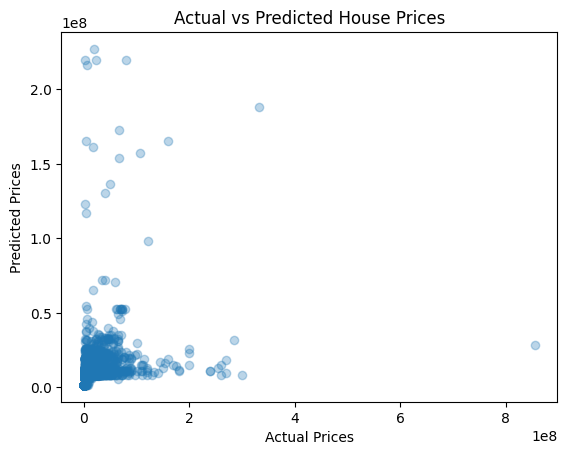

In [ ]:
# ================================================
# STEP 8: Evaluate Model
# ================================================
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📈 R²: {r2:.3f}")

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()


In [ ]:
# ================================================
# STEP 9: Save and Test Model
# ================================================
model_path = "../models/pipeline.joblib"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(pipeline, model_path)

print(f"💾 Model saved successfully at: {model_path}")

# Test loading and prediction
loaded_model = joblib.load(model_path)
sample = X_test.iloc[0:1]
pred_price = loaded_model.predict(sample)[0]
print("🧠 Sample Prediction:", round(pred_price, 2))


💾 Model saved successfully at: ../models/pipeline.joblib
🧠 Sample Prediction: 1.6531349e+06
